In [1]:
import pandas as pd
import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt

from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter, DerivedOutput, Function

In [2]:
def build_sis_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "susceptible",
        "infectious",
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["infectious"],
        timestep=0.01,
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": config["population"] - config["seed"], 
            "infectious": config["seed"],
        }
    )
    
    # Transitions
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=Parameter("recovery"),
        source="infectious", 
        dest="susceptible",
    )
    
    # Activity rate stratification
    activity_strat = Stratification(
        "activity",
        ["High", "Low"],
        compartments,
    )

    high_prop = Parameter("high_prop")
    low_prop = 1. - high_prop
    
    activity_strat.set_population_split(
        {
            "High": high_prop,
            "Low": low_prop,
        }
    )
    
    # Create the mixing matrix
    low_partner_change = Parameter("low_partner_change")
    high_partner_change = (Parameter("average_partner_change") - low_partner_change * low_prop) / high_prop  # Equation 8.15
    high_change_rate_abs = high_partner_change * high_prop  # Absolute partner change rate, high stratum
    low_change_rate_abs = low_partner_change * low_prop  # Absolute partner change rate, low stratum
    total_change_rate = high_change_rate_abs + low_change_rate_abs  # Total rate of partner changes across the population
    high_change_prop = high_change_rate_abs / total_change_rate  # Equation 8.20
    low_change_prop = low_change_rate_abs / total_change_rate
    
    def build_matrix(high_change_prop, low_change_prop):
        mixing_matrix = jnp.array([[high_change_prop, low_change_prop]])  # The "g" values
        mixing_matrix = jnp.repeat(mixing_matrix, 2, axis=0)  # Double up to a square array
        return mixing_matrix
    
    mixing_matrix = Function(build_matrix, (high_change_prop, low_change_prop))
    
    # The "c" values
    activity_strat.set_flow_adjustments(
        "infection",
        {
            "High": Multiply(high_partner_change),  # Or multiply top row of matrix by this
            "Low": Multiply(low_partner_change),  # Or multiply bottom row of matrix by this
        },
    )
    
    activity_strat.set_mixing_matrix(mixing_matrix)
    model.stratify_with(activity_strat)
    
    # Outputs
    model.request_output_for_compartments(
        "infectious",
        ["infectious"],
        save_results=False,
    )
    model.request_output_for_compartments(
        "total",
        compartments,
        save_results=False,
    )
    model.request_function_output(
        "Overall",
        DerivedOutput("infectious") / 
        DerivedOutput("total")
    )
    for stratum in ["High", "Low"]:
        model.request_output_for_compartments(
            f"infectiousX{stratum}",
            ["infectious"],
            strata={"activity": stratum},
            save_results=False,
        )
        model.request_output_for_compartments(
            f"totalX{stratum}",
            compartments,
            strata={"activity": stratum},
            save_results=False,
        )
        model.request_function_output(
            stratum,
            DerivedOutput(f"infectiousX{stratum}") / 
            DerivedOutput(f"totalX{stratum}")
        )
    model.request_output_for_flow(
        "incidence",
        "infection",
    )
    
    return model

In [3]:
model_config = {
    "end_time": 1000.,  # Run a bit longer to smooth out - doesn't work that well
    "population": 1.,
    "seed": 1e-6,
}

parameters = {
    "recovery": 6.,
    "contact_rate": 0.75,
    "high_prop": 0.02,
    "average_partner_change": 2.,
}

In [4]:
low_change_rates = np.concatenate((np.linspace(2., 1., 21), np.linspace(0.9, 0., 6)))
output_groups = ["Overall", "Low", "High"]
outputs = pd.DataFrame(index=low_change_rates, columns=output_groups)
sis_model = build_sis_model(model_config)
for low_change in low_change_rates:
    parameters.update({"low_partner_change": low_change})
    sis_model.run(parameters=parameters, solver="euler")
    outputs.loc[low_change] = sis_model.get_derived_outputs_df().loc[model_config["end_time"], :] * 100.

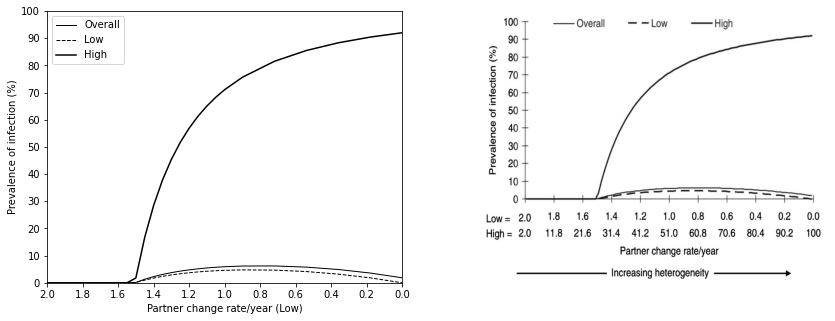

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

line_styles = ("-", "--", "-")
line_widths = (1., 1., 1.5)

for out, output_type in enumerate(outputs):
    left_ax.plot(
        outputs.index,
        outputs[output_type],
        color="k",
        label=output_type,
        linestyle=line_styles[out],
        linewidth=line_widths[out],
    )
left_ax.set_xlim(2., 0.)
left_ax.set_xticks(np.linspace(2., 0., 11))
left_ax.set_xlabel("Partner change rate/year (Low)")
left_ax.set_ylim(0., 100.)
left_ax.set_yticks(np.linspace(0., 100., 11))
left_ax.set_ylabel("Prevalence of infection (%)")
left_ax.legend()

image = plt.imread("./figures/fig_8_9.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");